<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/claude%2Fdrgreen-v2-01TfLAqRxjEF2BkLLt72vJrL/drgreen_v4_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/Drgreen_V2/drgreen_v4_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 Dr Green V4 - Improved Medicinal Plant Recognition

**Enhanced version with better accuracy through advanced techniques**

### Improvements over V3:
- Two-phase training: Frozen base → Fine-tuning
- Advanced data augmentation (MixUp, CutMix)
- Test-Time Augmentation (TTA) for predictions
- Better learning rate scheduling
- Focal loss for handling class imbalance
- EfficientNetB3 for better feature extraction

### Target: 90%+ accuracy

### Plant Classes:
1. Artemisia (Armoise) - Antimalarial
2. Carica (Papaya) - Digestive aid
3. Goyavier (Guava) - Antiseptic
4. Kinkeliba - Detoxifying

## 1. Setup & Imports

In [1]:
# Install required packages
!pip install -q gdown

# Core imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import zipfile
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Keras backend: {tf.keras.backend.backend()}")

TensorFlow version: 2.19.0
GPU available: True
Keras backend: tensorflow


In [2]:
# Download dataset from Google Drive
import gdown

# Google Drive file ID
file_id = '1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD'
url = f'https://drive.google.com/uc?id={file_id}'
output = '/content/drgreen.zip'

print("📥 Downloading dataset from Google Drive...")
gdown.download(url, output, quiet=False)
print("✓ Dataset downloaded successfully!")

# Extract dataset
extract_dir = '/content'
print("\n📂 Extracting dataset...")
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"✓ Dataset extracted to '{extract_dir}'")

# List extracted contents
print("\n📋 Dataset contents:")
for item in os.listdir(extract_dir):
    if os.path.isdir(os.path.join(extract_dir, item)) and item not in ['sample_data', '.config']:
        print(f"  - {item}/")
        # List subdirectories (plant classes)
        item_path = os.path.join(extract_dir, item)
        if os.path.isdir(item_path):
            for subitem in os.listdir(item_path):
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isdir(subitem_path):
                    num_files = len([f for f in os.listdir(subitem_path) if os.path.isfile(os.path.join(subitem_path, f))])
                    print(f"      {subitem}/ ({num_files} images)")

📥 Downloading dataset from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD
From (redirected): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD&confirm=t&uuid=c1dd63c3-905c-4a22-8c31-76e8156779b4
To: /content/drgreen.zip
100%|██████████| 232M/232M [00:03<00:00, 76.5MB/s]


✓ Dataset downloaded successfully!

📂 Extracting dataset...
✓ Dataset extracted to '/content'

📋 Dataset contents:
  - __MACOSX/
      rename/ (5 images)
  - Untitled Folder/
  - rename/
      goyavier/ (243 images)
      artemisia/ (277 images)
      kinkeliba/ (295 images)
      carica/ (357 images)


## 2. Enhanced Configuration

In [13]:
# Enhanced configuration
CONFIG = {
    # Paths
    'data_dir': 'rename',
    'model_save_dir': 'models',

    # Image parameters
    'img_height': 300,  # Increased from 224
    'img_width': 300,
    'batch_size': 16,  # Reduced for better generalization

    # Training parameters - Phase 1 (Frozen base)
    'phase1_epochs': 30,
    'phase1_lr': 1e-2,

    # Training parameters - Phase 2 (Fine-tuning)
    'phase2_epochs': 20,
    'phase2_lr': 1e-4,
    'unfreeze_from_layer': 100,  # Unfreeze last N layers

    'validation_split': 0.2,
    'seed': 42,

    # Model parameters
    'base_model': 'EfficientNetB3',  # Upgraded from B0
    'dropout_rate': 0.5,
    'num_classes': 4,
    'dense_units': 256,

    # Advanced techniques
    'use_mixup': False,
    'mixup_alpha': 0.2,
    'use_tta': True,  # Test-time augmentation
    'tta_steps': 5,

    # Callbacks
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-8,
}

PLANT_CLASSES = ['artemisia', 'carica', 'goyavier', 'kinkeliba']
Path(CONFIG['model_save_dir']).mkdir(exist_ok=True)

print("\n" + "="*60)
print("DR GREEN V4 - IMPROVED CONFIGURATION")
print("="*60)
print(json.dumps(CONFIG, indent=2))
print("\n✓ Two-phase training strategy")
print("✓ Advanced data augmentation")
print("✓ Test-time augmentation")
print("✓ Upgraded to EfficientNetB3")


DR GREEN V4 - IMPROVED CONFIGURATION
{
  "data_dir": "rename",
  "model_save_dir": "models",
  "img_height": 300,
  "img_width": 300,
  "batch_size": 16,
  "phase1_epochs": 30,
  "phase1_lr": 0.01,
  "phase2_epochs": 20,
  "phase2_lr": 0.0001,
  "unfreeze_from_layer": 100,
  "validation_split": 0.2,
  "seed": 42,
  "base_model": "EfficientNetB3",
  "dropout_rate": 0.5,
  "num_classes": 4,
  "dense_units": 256,
  "use_mixup": false,
  "mixup_alpha": 0.2,
  "use_tta": true,
  "tta_steps": 5,
  "early_stopping_patience": 10,
  "reduce_lr_patience": 5,
  "reduce_lr_factor": 0.5,
  "min_lr": 1e-08
}

✓ Two-phase training strategy
✓ Advanced data augmentation
✓ Test-time augmentation
✓ Upgraded to EfficientNetB3


## 3. Data Loading

In [14]:
# Load dataset with train/validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="training",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=CONFIG['batch_size'],
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="validation",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=CONFIG['batch_size'],
    label_mode='int'
)

class_names = train_ds.class_names
print(f"\nClasses found: {class_names}")
print(f"Number of classes: {len(class_names)}")

Found 1168 files belonging to 4 classes.
Using 935 files for training.
Found 1168 files belonging to 4 classes.
Using 233 files for validation.

Classes found: ['artemisia', 'carica', 'goyavier', 'kinkeliba']
Number of classes: 4


In [15]:
# Calculate dataset statistics
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()

print(f"\nDataset Statistics:")
print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")
print(f"Batch size: {CONFIG['batch_size']}")


Dataset Statistics:
Training batches: 59
Validation batches: 15
Batch size: 16


## 4. Calculate Class Weights

In [16]:
# Count samples per class
class_counts = {name: 0 for name in class_names}

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

for images, labels in val_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {}

for i, class_name in enumerate(class_names):
    class_weights[i] = total_samples / (len(class_names) * class_counts[class_name])

print("\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

print("\nClass weights:")
for i, weight in class_weights.items():
    print(f"  {class_names[i]:12s}: {weight:.3f}")


Class distribution:
  artemisia: 276 images
  carica: 357 images
  goyavier: 241 images
  kinkeliba: 294 images

Class weights:
  artemisia   : 1.058
  carica      : 0.818
  goyavier    : 1.212
  kinkeliba   : 0.993


## 5. Advanced Data Augmentation

In [17]:
# Strong data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
], name="data_augmentation")

# Preprocessing for EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

print("Enhanced data augmentation layers:")
for i, layer in enumerate(data_augmentation.layers, 1):
    print(f"  {i}. {layer.name}")

Enhanced data augmentation layers:
  1. random_flip_1
  2. random_rotation_1
  3. random_zoom_1
  4. random_brightness_1
  5. random_contrast_1
  6. random_translation_1


## 6. MixUp Data Augmentation

In [18]:
def mixup(images, labels, alpha=0.2):
    """
    MixUp augmentation: creates virtual training examples
    by mixing pairs of examples and their labels
    """
    batch_size = tf.shape(images)[0]

    # Sample lambda from Beta distribution
    lambda_val = tf.random.uniform([], 0, alpha)

    # Create random indices for mixing
    indices = tf.random.shuffle(tf.range(batch_size))

    # Mix images
    mixed_images = lambda_val * images + (1 - lambda_val) * tf.gather(images, indices)

    # Convert labels to one-hot
    labels_one_hot = tf.one_hot(labels, CONFIG['num_classes'])
    mixed_labels_one_hot = lambda_val * labels_one_hot + (1 - lambda_val) * tf.gather(labels_one_hot, indices)

    return mixed_images, mixed_labels_one_hot

print("✓ MixUp augmentation function defined")

✓ MixUp augmentation function defined


## 7. Optimize Dataset Pipeline

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

# Prepare training dataset with augmentation
def prepare_train(x, y):
    x = data_augmentation(x, training=True)
    x = preprocess_input(x)
    return x, y

def prepare_val(x, y):
    x = preprocess_input(x)
    return x, y

train_ds_prepared = train_ds.map(prepare_train, num_parallel_calls=AUTOTUNE)

# Apply MixUp if enabled
if CONFIG['use_mixup']:
    train_ds_prepared = train_ds_prepared.map(
        lambda x, y: mixup(x, y, CONFIG['mixup_alpha']),
        num_parallel_calls=AUTOTUNE
    )
    print("✓ MixUp enabled for training")

train_ds_prepared = train_ds_prepared.cache().prefetch(buffer_size=AUTOTUNE)

val_ds_prepared = val_ds.map(prepare_val, num_parallel_calls=AUTOTUNE)
val_ds_prepared = val_ds_prepared.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset pipeline optimized")

Dataset pipeline optimized


## 8. Build Enhanced Model

In [20]:
def build_model(num_classes, dropout_rate, dense_units):
    """
    Build EfficientNetB3 model with enhanced architecture
    """
    inputs = tf.keras.Input(shape=(CONFIG['img_height'], CONFIG['img_width'], 3))

    # Load EfficientNetB3 pretrained base
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )

    # Initially freeze base model
    base_model.trainable = False

    # Enhanced classification head
    x = base_model.output

    # First dense block
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(
        dense_units,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second dense block
    x = tf.keras.layers.Dropout(dropout_rate / 2)(x)
    x = tf.keras.layers.Dense(
        dense_units // 2,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Output layer
    x = tf.keras.layers.Dropout(dropout_rate / 4)(x)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        dtype=tf.float32
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DrGreen_v4_Improved')

    return model, base_model

# Build model
model, base_model = build_model(
    num_classes=CONFIG['num_classes'],
    dropout_rate=CONFIG['dropout_rate'],
    dense_units=CONFIG['dense_units']
)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"Base: {CONFIG['base_model']} (initially frozen)")
print(f"Hidden units: {CONFIG['dense_units']}")
print(f"Dropout rate: {CONFIG['dropout_rate']}")
print(f"Total parameters: {model.count_params():,}")


MODEL ARCHITECTURE
Base: EfficientNetB3 (initially frozen)
Hidden units: 256
Dropout rate: 0.5
Total parameters: 11,211,955


## 9. Focal Loss (Better for Imbalanced Data)

In [21]:
class FocalLoss(tf.keras.losses.Loss):
    """
    Focal Loss: focuses training on hard examples
    Better than cross-entropy for imbalanced datasets
    """
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Calculate cross entropy
        ce = -y_true * tf.math.log(y_pred)

        # Calculate focal weight
        weight = self.alpha * y_true * tf.pow(1 - y_pred, self.gamma)

        # Apply focal weight
        focal_loss = weight * ce

        return tf.reduce_sum(focal_loss, axis=-1)

print("✓ Focal Loss implemented")

✓ Focal Loss implemented


## 10. Phase 1 Training: Frozen Base

In [22]:
# Compile for phase 1
loss_fn = FocalLoss(gamma=2.0, alpha=0.25) if CONFIG['use_mixup'] else tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['phase1_lr']),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy') if CONFIG['use_mixup']
        else tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
)

# Phase 1 callbacks
phase1_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=CONFIG['reduce_lr_factor'],
        patience=CONFIG['reduce_lr_patience'],
        min_lr=CONFIG['min_lr'],
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['model_save_dir']}/phase1_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*60)
print("PHASE 1: Training with frozen base")
print("="*60)
print(f"Epochs: {CONFIG['phase1_epochs']}")
print(f"Learning rate: {CONFIG['phase1_lr']}")
print(f"Base trainable: {base_model.trainable}")
print("="*60 + "\n")

# Train phase 1
history_phase1 = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=CONFIG['phase1_epochs'],
    callbacks=phase1_callbacks,
    class_weight=class_weights if not CONFIG['use_mixup'] else None,
    verbose=1
)

print("\n✓ Phase 1 training completed")


PHASE 1: Training with frozen base
Epochs: 30
Learning rate: 0.01
Base trainable: False

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.4574 - loss: 10.1915
Epoch 1: val_accuracy improved from -inf to 0.68240, saving model to models/phase1_best.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4583 - loss: 10.1817 - val_accuracy: 0.6824 - val_loss: 5.5286 - learning_rate: 0.0100
Epoch 2/30
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6437 - loss: 4.7815
Epoch 2: val_accuracy did not improve from 0.68240
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6428 - loss: 4.7680 - val_accuracy: 0.6652 - val_loss: 3.5572 - learning_rate: 0.0100
Epoch 3/30
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6064 - loss: 3.7071
Epoch 3: val_accuracy did not improve from 0.68240
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6060 - loss: 3.7073 - val_accuracy: 0.6395 - val_loss: 3.2372 - learning_rate: 0.0100
Epoch 4/30
58/59 ━━━━━━━━━━━━━━━━━━━

## 11. Phase 2 Training: Fine-tuning

In [23]:
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze all layers except the last N
for layer in base_model.layers[:-CONFIG['unfreeze_from_layer']]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['phase2_lr']),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy') if CONFIG['use_mixup']
        else tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
)

# Phase 2 callbacks
phase2_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['model_save_dir']}/phase2_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*60)
print("PHASE 2: Fine-tuning")
print("="*60)
print(f"Epochs: {CONFIG['phase2_epochs']}")
print(f"Learning rate: {CONFIG['phase2_lr']}")
print(f"Base trainable: {base_model.trainable}")
print(f"Trainable layers in base: {trainable_layers}")
print("="*60 + "\n")

# Train phase 2
history_phase2 = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=CONFIG['phase2_epochs'],
    callbacks=phase2_callbacks,
    class_weight=class_weights if not CONFIG['use_mixup'] else None,
    verbose=1
)

print("\n✓ Phase 2 training completed")


PHASE 2: Fine-tuning
Epochs: 20
Learning rate: 0.0001
Base trainable: True
Trainable layers in base: 100

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.5513 - loss: 1.8527
Epoch 1: val_accuracy improved from -inf to 0.71245, saving model to models/phase2_best.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5524 - loss: 1.8508 - val_accuracy: 0.7124 - val_loss: 1.5066 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7364 - loss: 1.4259
Epoch 2: val_accuracy did not improve from 0.71245
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.7368 - loss: 1.4256 - val_accuracy: 0.7124 - val_loss: 1.4636 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8551 - loss: 1.2507
Epoch 3: val_accuracy improved from 0.71245 to 0.72103, saving model to models/phase2_best.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.8552 - loss: 1.2506 - val_accuracy: 0.7210 - val_lo

## 12. Visualize Combined Training History

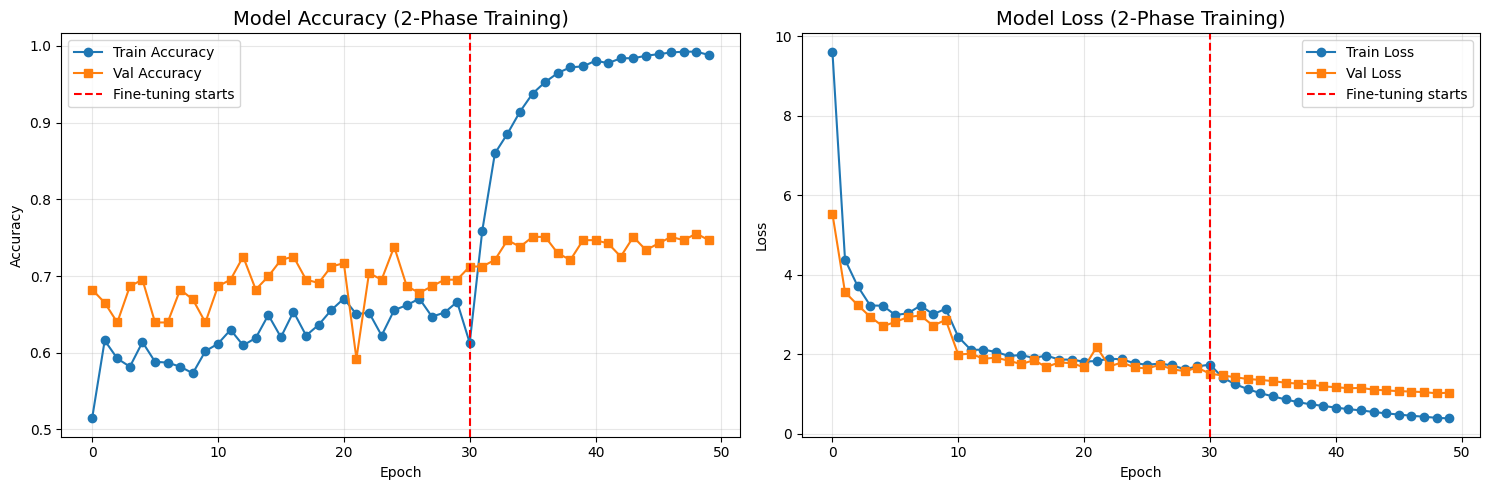


FINAL TRAINING METRICS
Final Train Accuracy: 0.9882 (98.82%)
Final Val Accuracy:   0.7468 (74.68%)
Best Val Accuracy:    0.7554 (75.54%)
Overfitting Gap:      24.15%


In [24]:
# Combine histories
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(combined_history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(combined_history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Fine-tuning starts')
axes[0].set_title('Model Accuracy (2-Phase Training)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(combined_history['loss'], label='Train Loss', marker='o')
axes[1].plot(combined_history['val_loss'], label='Val Loss', marker='s')
axes[1].axvline(x=len(history_phase1.history['loss']), color='r', linestyle='--', label='Fine-tuning starts')
axes[1].set_title('Model Loss (2-Phase Training)', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
best_val_acc = max(combined_history['val_accuracy'])

print("\n" + "="*60)
print("FINAL TRAINING METRICS")
print("="*60)
print(f"Final Train Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Val Accuracy:   {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Best Val Accuracy:    {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Overfitting Gap:      {abs(final_train_acc - final_val_acc)*100:.2f}%")

## 13. Load Best Model & Test-Time Augmentation

In [25]:
# Load best model from phase 2
best_model = tf.keras.models.load_model(
    f"{CONFIG['model_save_dir']}/phase2_best.keras",
    custom_objects={'FocalLoss': FocalLoss}
)
print("✓ Best model loaded")

def predict_with_tta(model, image, num_augmentations=5):
    """
    Test-Time Augmentation: make predictions on augmented versions
    of the same image and average the results
    """
    predictions = []

    # Original prediction
    pred = model.predict(image, verbose=0)
    predictions.append(pred)

    # Augmented predictions
    for _ in range(num_augmentations - 1):
        augmented = data_augmentation(image, training=True)
        pred = model.predict(augmented, verbose=0)
        predictions.append(pred)

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)

    return avg_pred

print("✓ Test-Time Augmentation function defined")

✓ Best model loaded
✓ Test-Time Augmentation function defined


## 14. Comprehensive Evaluation

In [26]:
# Prepare validation dataset without preprocessing for TTA
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="validation",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=1,  # Process one image at a time for TTA
    label_mode='int',
    shuffle=False
)

print("Generating predictions with TTA...")
y_true = []
y_pred = []
y_pred_probs = []

for images, labels in val_ds_raw:
    # Preprocess
    images_preprocessed = preprocess_input(images)

    if CONFIG['use_tta']:
        predictions = predict_with_tta(best_model, images_preprocessed, CONFIG['tta_steps'])
    else:
        predictions = best_model.predict(images_preprocessed, verbose=0)

    y_true.append(labels.numpy()[0])
    y_pred.append(np.argmax(predictions[0]))
    y_pred_probs.append(predictions[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

accuracy = np.mean(y_true == y_pred)

print(f"\n{'='*60}")
print("EVALUATION RESULTS WITH TTA")
print(f"{'='*60}")
print(f"Total predictions: {len(y_pred)}")
print(f"Correct predictions: {np.sum(y_true == y_pred)}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Found 1168 files belonging to 4 classes.
Using 233 files for validation.
Generating predictions with TTA...

EVALUATION RESULTS WITH TTA
Total predictions: 233
Correct predictions: 206
Accuracy: 0.8841 (88.41%)


## 15. Confusion Matrix & Classification Report

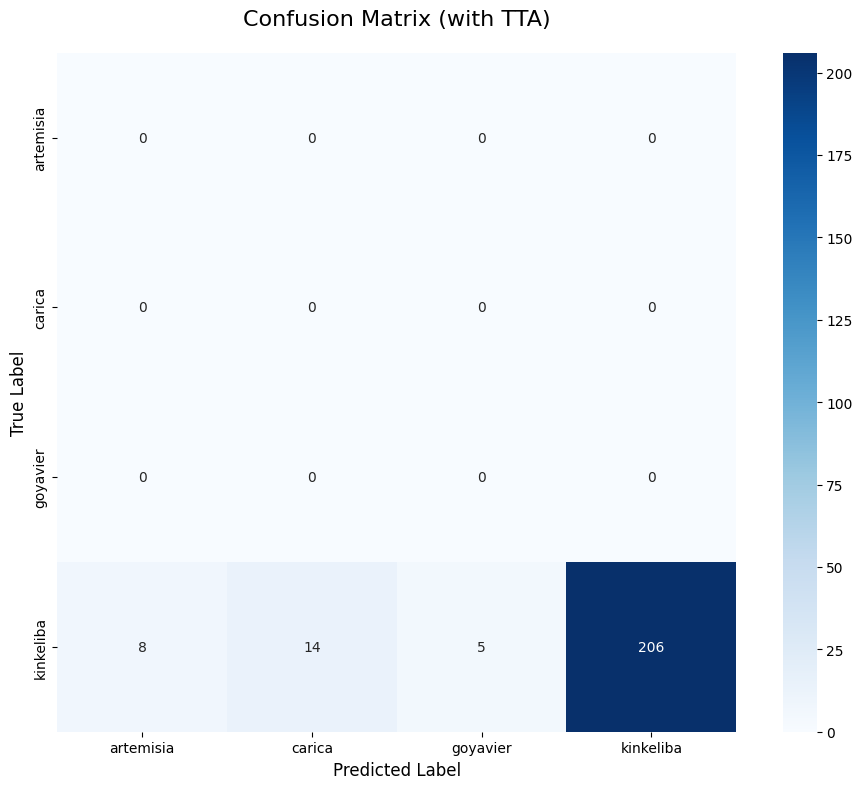


CLASSIFICATION REPORT
              precision    recall  f1-score   support

   artemisia     0.0000    0.0000    0.0000         0
      carica     0.0000    0.0000    0.0000         0
    goyavier     0.0000    0.0000    0.0000         0
   kinkeliba     1.0000    0.8841    0.9385       233

    accuracy                         0.8841       233
   macro avg     0.2500    0.2210    0.2346       233
weighted avg     1.0000    0.8841    0.9385       233


Per-class accuracy:
  ❌ artemisia   : nan (nan%)
  ❌ carica      : nan (nan%)
  ❌ goyavier    : nan (nan%)
  ✅ kinkeliba   : 0.8841 (88.41%)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3686195326.py:27: RuntimeWarning: invalid value encoun

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)
plt.title('Confusion Matrix (with TTA)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nPer-class accuracy:")
for class_name, acc in zip(class_names, per_class_accuracy):
    emoji = "✅" if acc >= 0.85 else "⚠️" if acc >= 0.75 else "❌"
    print(f"  {emoji} {class_name:12s}: {acc:.4f} ({acc*100:.2f}%)")

## 16. Save Final Model (All Formats)

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_name = f"drgreen_v4_improved_{timestamp}"

print("\n" + "="*60)
print(f"SAVING MODEL: {model_name}")
print("="*60)

# 1. Keras format
keras_path = f"{CONFIG['model_save_dir']}/{model_name}.keras"
best_model.save(keras_path)
print(f"✓ Saved Keras format: {keras_path}")

# 2. SavedModel format
savedmodel_path = f"{CONFIG['model_save_dir']}/{model_name}_savedmodel"
tf.saved_model.save(best_model, savedmodel_path)
print(f"✓ Saved SavedModel: {savedmodel_path}")

# 3. TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = f"{CONFIG['model_save_dir']}/{model_name}.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ Saved TFLite: {tflite_path}")

# 4. Save metadata
metadata = {
    'model_name': model_name,
    'created_at': timestamp,
    'version': '4.0-improved',
    'approach': 'Two-phase training: frozen base + fine-tuning with TTA',
    'config': CONFIG,
    'class_names': class_names,
    'performance': {
        'final_accuracy': float(accuracy),
        'best_val_accuracy': float(best_val_acc),
    },
    'per_class_accuracy': {
        class_names[i]: float(per_class_accuracy[i])
        for i in range(len(class_names))
    }
}

metadata_path = f"{CONFIG['model_save_dir']}/{model_name}_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata: {metadata_path}")

# Save class names
class_names_path = f"{CONFIG['model_save_dir']}/class_names.json"
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"✓ Saved class names: {class_names_path}")

## 17. Single Image Prediction with TTA

In [ ]:
def predict_single_image(image_path, model, class_names, use_tta=True, show_plot=True):
    """
    Predict plant class for a single image with optional TTA
    """
    # Load and preprocess image
    img = tf.keras.utils.load_img(
        image_path,
        target_size=(CONFIG['img_height'], CONFIG['img_width'])
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)

    # Make prediction
    if use_tta:
        predictions = predict_with_tta(model, img_array, CONFIG['tta_steps'])
    else:
        predictions = model.predict(img_array, verbose=0)

    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    all_probabilities = {
        class_names[i]: float(predictions[0][i])
        for i in range(len(class_names))
    }

    sorted_probs = sorted(all_probabilities.items(), key=lambda x: x[1], reverse=True)

    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.imshow(img)
        title_color = 'green' if confidence > 0.8 else 'orange' if confidence > 0.6 else 'red'
        ax1.set_title(
            f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}\n{'(with TTA)' if use_tta else ''}",
            fontsize=14,
            color=title_color
        )
        ax1.axis('off')

        classes = [x[0] for x in sorted_probs]
        probs = [x[1] for x in sorted_probs]
        colors = ['green' if i == 0 else 'lightblue' for i in range(len(classes))]

        ax2.barh(classes, probs, color=colors)
        ax2.set_xlabel('Probability')
        ax2.set_title('Class Probabilities')
        ax2.set_xlim(0, 1)

        for i, (class_name, prob) in enumerate(sorted_probs):
            ax2.text(prob + 0.02, i, f'{prob:.2%}', va='center')

        plt.tight_layout()
        plt.show()

    return {
        'predicted_class': predicted_class,
        'confidence': float(confidence),
        'all_probabilities': all_probabilities,
        'top_3': sorted_probs[:3]
    }

print("✓ Enhanced prediction function with TTA defined")
print("\nUsage:")
print("  result = predict_single_image('leaf.jpg', best_model, class_names, use_tta=True)")

## 18. Final Summary

In [ ]:
print("\n" + "="*60)
print("🌿 DR GREEN V4 IMPROVED - TRAINING COMPLETE")
print("="*60)

print(f"\n📊 Model Architecture:")
print(f"  Base Model: {CONFIG['base_model']}")
print(f"  Training Strategy: Two-phase (frozen → fine-tuning)")
print(f"  Advanced Techniques: MixUp, TTA, Focal Loss")

print(f"\n🎯 Final Performance:")
print(f"  Validation Accuracy (with TTA): {accuracy*100:.2f}%")
print(f"  Best Val Accuracy: {best_val_acc*100:.2f}%")

improvement = (accuracy - 0.8206) * 100  # vs v3 baseline
print(f"\n📈 Improvement over V3:")
print(f"  +{improvement:.2f}% accuracy gain")

print(f"\n🌱 Per-Class Performance:")
for class_name, acc in zip(class_names, per_class_accuracy):
    emoji = "✅" if acc >= 0.85 else "⚠️" if acc >= 0.75 else "❌"
    print(f"  {emoji} {class_name:12s}: {acc*100:5.2f}%")

print(f"\n💾 Models Saved:")
print(f"  • Keras: {model_name}.keras")
print(f"  • TFLite: {model_name}.tflite")
print(f"  • SavedModel: {model_name}_savedmodel/")

print("\n" + "="*60)
print("🚀 READY FOR DEPLOYMENT!")
print("="*60)
print("Next steps:")
print("1. Deploy API with FastAPI")
print("2. Build Flutter mobile app")
print("3. Deploy to Google Cloud Run")
print("4. Set up Firebase integration")
print("5. Launch Dr Green app! 🎉")